# load modules

In [1]:
import os,sys,re
import glob
import pandas as pd
import scipy.io
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import time 
import math
import tifffile as tiff
import tensorflow as tf
import pickle#save multiple variables into a pickle file
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objects as go
pyo.init_notebook_mode()

%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

#add folder to the system-path at runtime, for importing file in another folder
if '../shiny_files' not in sys.path:
    sys.path.insert(0, '../shiny_files')
import func_get_data as fx

# load the data 

In [2]:
version_name = 'true_tif' #'v11'
input_dir = 'F:\emb_data'
#input_dir = os.path.join(os.getcwd(),'..','..','emb_data')

#use the below arguments and save different csv file
use_predict_tif = False #(False):use true labels tif . (True or has_processed=False): use predict.tif 
#default is to plot tp emb.
plot_fn = True #(TRUE):plot fn emb. from false_positive_index.txt 
plot_fp = False 
inv_c = True #stem curved like inverse of letter C or not

'''
Paths
'''
disk_path = os.path.join(input_dir,version_name)
all_folders_name = np.sort(os.listdir(disk_path))

all_folders_dir = [os.path.join(disk_path,folder) for folder in all_folders_name]

n_folders = len(all_folders_name)#[Diane 0522]

#output folder name based on user-specified arguments
if use_predict_tif:
    folder_tag1 = 'pred_tif'
else:
    folder_tag1= 'true_tif'

if plot_fn:
    folder_tag2 = 'has_fn'
else:
    folder_tag2 = 'no_fn'

if plot_fp:
    folder_tag3 = 'has_fp'
else:
    folder_tag3 = 'no_fp'

# Define the functions

In [3]:
def compute_cc_emb_info(folder_idx):
    folder_name_short = all_folders_name[folder_idx]
    dir_path = all_folders_dir[folder_idx]
    input_folder_tag = '_'.join((folder_tag1,folder_tag2,folder_tag3))
    input_folder = os.path.join(dir_path,input_folder_tag)
    pickle_dict = pickle.load(open(os.path.join(input_folder,'shinydata.pkl'),"rb"))#dictionary
    plot_mat_time = pickle_dict['plot_mat_time']
    cc_emb_info = plot_mat_time.drop(['row','col'], axis = 1)#drop two columns that are of pixel level (smaller than cc level)
    cc_emb_info = cc_emb_info.drop_duplicates()#keep unique rows
    x_mean = np.mean(plot_mat_time['col'])#col mean of one embolism event
    #[Diane 0522]returns plot_mat_time, else there'll be err in compute_col_dist
    return cc_emb_info, x_mean, folder_name_short, plot_mat_time 

In [4]:
def compute_col_dist(cc_emb_info,x_mean,plot_mat_time):
    cc_centroid_col_dist_to_mean = cc_emb_info['cc_centroid_col'].apply(lambda x: abs(x - x_mean))
    cc_centroid_col_dist_to_mean = pd.concat([cc_centroid_col_dist_to_mean.reset_index(drop=True),cc_emb_info['time_since_start(mins)'].reset_index(drop=True)],axis=1)
    cc_centroid_col_dist_to_mean = cc_centroid_col_dist_to_mean.rename(columns = {'cc_centroid_col':'cc_centroid_col_dist_to_mean'})
    cc_col_dist_mean = cc_centroid_col_dist_to_mean.groupby(['time_since_start(mins)'])['cc_centroid_col_dist_to_mean'].mean().reset_index()
    cc_col_dist_mean = cc_col_dist_mean.rename(columns = {'cc_centroid_col_dist_to_mean':'cc_cen_col_dist_mean'})
    #summary_statistics = plot_mat_time.groupby('number_emb').mean().iloc[:,-6:]#img level, takes the "weighted" mean of other columns, "weight" would be porportional to the number of pixels in an embolism event
    summary_statistics = plot_mat_time.groupby('cc_num_emb').mean().groupby('number_emb').mean().drop(['row','col'], axis = 1)#[Diane 0522]
    summary_statistics = summary_statistics.merge(cc_col_dist_mean, on = 'time_since_start(mins)')
    summary_statistics['folder_name'] = folder_name_short.lower()
    return summary_statistics

In [5]:
def summary_statistics_all(n_folders):
    total_summary_stats = pd.DataFrame()
    for i in tqdm(range(n_folders)):
        cc_emb_info, x_mean, folder_name_short , plot_mat_time = compute_cc_emb_info(i)#[Diane 0522]
        summary_statistics = compute_col_dist(cc_emb_info,x_mean, plot_mat_time)
        summary_statistics['folder_name'] = folder_name_short.lower()#[Diane 0522]
        total_summary_stats = total_summary_stats.append(summary_statistics)
    return total_summary_stats

# Cumulative embolized area vs time

In [6]:
cc_area_summary = pd.DataFrame()
for i in tqdm(range(n_folders)):
    cc_emb_info, x_mean, folder_name_short, _ = compute_cc_emb_info(i)#[Diane 0522]
    summary_statistics = cc_emb_info.groupby('time_since_start(mins)').agg({'cc_area':'sum','number_emb':'median'}).reset_index()
    summary_statistics['folder_name'] = folder_name_short.lower()
    summary_statistics['cumsum_cc_area'] = summary_statistics.cc_area.cumsum()/summary_statistics.cc_area.cumsum().max()
    cc_area_summary = cc_area_summary.append(summary_statistics)

In [7]:
cc_area_summary 

time_since_start(mins)  cc_area  number_emb   folder_name  cumsum_cc_area
0                        39   5803.0           1  alclat4_stem        0.035948
1                       101   7752.0           2  alclat4_stem        0.083970
2                       124    145.0           3  alclat4_stem        0.084869
3                       235    617.0           4  alclat4_stem        0.088691
4                       336    911.0           5  alclat4_stem        0.094334
..                      ...      ...         ...           ...             ...
436                    2088     86.0         437  slober3_stem        0.997906
437                    2090    127.0         438  slober3_stem        0.998465
438                    2141    156.0         439  slober3_stem        0.999151
439                    2185    132.0         440  slober3_stem        0.999732
440                    2187     61.0         441  slober3_stem        1.000000

[1772 rows x 5 columns]

In [8]:
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objects as go
pyo.init_notebook_mode()
fig = px.line(cc_area_summary, x="time_since_start(mins)", y="cumsum_cc_area", color = 'folder_name')
fig.show()

In [9]:
#fig.write_html("percentage.html")#save above fig into html

# Total summary statistics for all folders

doesn't include pixel position of embolism

In [10]:
total_summary_stats = summary_statistics_all(n_folders)#[Diane 0522]
all_folders_name_short = np.unique(total_summary_stats.folder_name)#[Diane 0522]

In [11]:
total_summary_stats#[Diane 0522]

cc_width   cc_height      cc_area  cc_centroid_row  cc_centroid_col  \
0    15.357143   52.357143   414.500000       434.877070       252.507657   
1    17.428571  119.857143  1107.428571       564.288607       168.521666   
2     5.200000    9.400000    29.000000       741.433329       192.018320   
3     9.500000   45.500000   308.500000       403.225958       225.267029   
4    10.100000   18.900000    91.100000       395.972303       225.071215   
..         ...         ...          ...              ...              ...   
436   3.750000    8.500000    21.500000       141.440882       248.938937   
437   7.000000   34.000000   127.000000       113.535433       250.755906   
438   4.750000   12.000000    39.000000       676.280208       227.292708   
439   8.000000   28.000000   132.000000       832.810606       143.401515   
440   5.000000   18.000000    61.000000       788.918033       142.081967   

     time_since_start(mins)  cc_cen_col_dist_mean   folder_name  
0                        39             45.246311  alclat4_stem  
1                       101             38.739680  alclat4_stem  
2                       124             15.243025  alclat4_stem  
3                       235             18.005683  alclat4_stem  
4                       336             17.809870  alclat4_stem  
..                      ...                   ...           ...  
436                    2088             83.981557  slober3_stem  
437                    2090             85.798526  slober3_stem  
438                    2141             70.125130  slober3_stem  
439                    2185             21.555864  slober3_stem  
440                    2187             22.875412  slober3_stem  

[1772 rows x 8 columns]

# Potential Problem of the above total_summary_stats:

- <span style="color:red">  Didn't consider shrinkage/stem curved yet </span>
- <span style="color:red">  Didn't consider multiple embolism events in one image </span> As we grouped it by 'time_since_start(mins)' or 'number_emb'(at img level) and took the mean. We assumed the emb. in one img are all from the same embolism events, which might not be true.
    - cc_num_emb might not be the same as emb event index (cuz same emb. event might be broken into small pieces)
    - number_emb might not be the same as emb event index (cuz multiple embolism events can take place in one img)

# Distribution of centroid position (might be incorrect, see the reason above)

should be centroid position for every embolism event in an experiment

Text(0.5, 0.98, 'alclat4_stem')

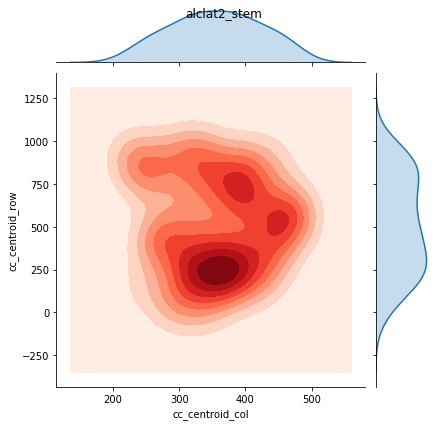

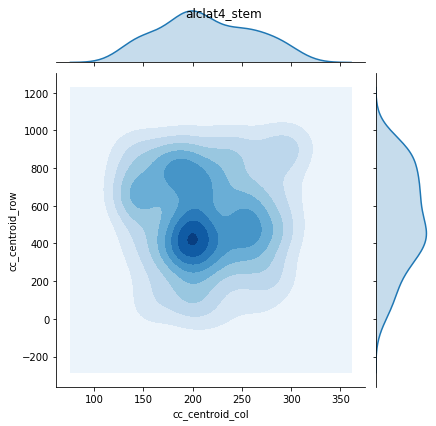

In [12]:
folder_idx1 = 0#[Diane 0522] introduce folder_idx and plot title
folder_idx2 = 1

ss_1 = total_summary_stats[total_summary_stats.folder_name == all_folders_name_short[folder_idx1]]
ss_2 = total_summary_stats[total_summary_stats.folder_name == all_folders_name_short[folder_idx2]]
#fig, ax = plt.subplots(1,2,figsize = (10,10))
fig1 = sns.jointplot(y = ss_1.cc_centroid_row , x= ss_1.cc_centroid_col,cmap="Reds",kind = 'kde')
fig1.fig.suptitle("%s" % all_folders_name_short[folder_idx1])#[Diane 0522]
fig2 = sns.jointplot(y = ss_2.cc_centroid_row , x= ss_2.cc_centroid_col,cmap="Blues",kind = 'kde')
fig2.fig.suptitle("%s" % all_folders_name_short[folder_idx2])

In [13]:
fig = px.scatter(total_summary_stats, x="time_since_start(mins)", y="cc_cen_col_dist_mean", color="folder_name",size = 'cc_area')
fig.show()

# Inter-event Distance vs Inter-event Time

- distance of mean centroid col position between 2 consecutive images

 - mean is taken across all embolism events in one image

In [14]:
#input:total_summary_stats
all_inter_event_dist_time = pd.DataFrame()
all_folders_name_short = np.unique(total_summary_stats.folder_name)#[Diane 0522]
for folder_name_short in all_folders_name_short:#folder_idx = 0
    ss = total_summary_stats[total_summary_stats.folder_name == folder_name_short]
    #print(ss)#8 cols: cc_width,cc_height, cc_area, cc_centroid_row, cc_centroid_col, time_since_start(mins), cc_cen_col_dist_mean, folder_name
    
    inter_event_col_dist = abs(ss['cc_centroid_col'].diff())[1:]#the first row (index 0) would be NaN -> drop it. 
    #Now index is starting with 1. if row index = i, it means it's the distance btw (i+1)-th embolism and i-th embolism event (i starts with 1)
    inter_event_col_dist = inter_event_col_dist.rename('inter_event_col_dist')#a series, not pd --> a different rename method
    
    inter_event_time= abs(ss['time_since_start(mins)'].diff())[1:]
    inter_event_time = inter_event_time.rename('inter_event_time(min)')
    
    inter_event_dist_time = inter_event_col_dist.to_frame().join(inter_event_time.to_frame())
    inter_event_dist_time
    inter_event_dist_time['folder_name'] = folder_name_short#add a col for foldername, s.t. when append tp all_inter_evennt_dist_time, we can know inter_event_dist_time is for which folder 
    
    #get species name and relative index
    species_and_num =  folder_name_short.split("_")#ex: ['dacexc5.2', 'stem']
    species_name = species_and_num[0][0:6]#ex: dacexc
    inter_event_dist_time['species'] = species_name
    if all_inter_event_dist_time.size ==0 :#first folder
        rel_exp_idx = 1
    else:
        if prev_species != species_name:#not the same species as the ones that have been added to all_inter_event_dist_time
            rel_exp_idx = 1
        else:
            rel_exp_idx += 1
    prev_species = species_name#for next round
    inter_event_dist_time['rel_exp_idx'] = rel_exp_idx#realtive experiment index, used for plotting
    #fig = px.scatter(inter_event_dist_time, x="inter_event_col_dist", y="inter_event_time(min)", trendline="ols")
    #fig.update_layout(
    #    height=300,
    #    width = 300,
    #    title_text=folder_name_short
    #)

    #fig.show()
    
    all_inter_event_dist_time = all_inter_event_dist_time.append(inter_event_dist_time)
    
#return all_inter_event_dist_time

In [15]:
all_rel_exp_idx = np.unique(all_inter_event_dist_time.rel_exp_idx).tolist()
all_species = np.unique(all_inter_event_dist_time.species).tolist()

#fig = px.scatter(all_inter_event_dist_time, x="inter_event_time(min)", y="inter_event_col_dist", facet_row="species", facet_col="rel_exp_idx", trendline="ols", color='species',
#          category_orders={"rel_exp_idx": all_rel_exp_idx, "species":all_species})
#fig.update_layout(
#        height= 200*len(all_species),
#        width = 150*len(all_rel_exp_idx),
#        title_text='Inter-Event Time vs Inter-Event Distance (Shared Axis) (Haven\'t accounted for shifting/shrinking )'
#    )
#fig.show()

In [16]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Initialize figure with subplots
fig1 = make_subplots(
    rows=len(all_species), cols=len(all_rel_exp_idx), subplot_titles=all_rel_exp_idx,
    x_title = "inter-event time(min)",
    y_title = "inter-event centroid column distance (pixel)"
)

for folder_name_short in all_folders_name_short:
    inter_event_dist_time = all_inter_event_dist_time[all_inter_event_dist_time.folder_name == folder_name_short]
    
    #for plotting
    species_name = np.unique(inter_event_dist_time["species"])
    species_idx = np.where(all_species==species_name)[0][0] #starts by 0
    fig_row_idx = int(species_idx + 1)#starts by 1
    #have to cast from numpy.int to int else will meet the following error:
    #ValueError: 
    #    If specified, the rows parameter must be a list or tuple of integers
    #    of length 1 (The number of traces being added)
    #ref: https://github.com/AppliedAcousticsChalmers/sound_field_analysis-py/issues/13
    
    if len(species_name)!=1:#check if len(species_name) is 1
        sys.exit("len(species_name) != 1, species_name:",species_name, " while folder_name_short=",folder_name_short)
        
    rel_exp_idx_arr = np.unique(inter_event_dist_time["rel_exp_idx"])#starts by 1, can be used as column index for plotting directly, as long as it's not empty
    if len(rel_exp_idx_arr)!=1:#check if len(rel_exp_idx_arr) is 1
        sys.exit("len(rel_exp_idx) != 1, rel_exp_idx_arr:",rel_exp_idx_arr, " for folder_name_short=",folder_name_short)
    else:
        fig_col_idx = int(rel_exp_idx_arr[0])
    #print(folder_name_short,fig_row_idx,fig_col_idx)    
    # Add traces
    fig1.add_scatter(x=inter_event_dist_time["inter_event_time(min)"], y=inter_event_dist_time["inter_event_col_dist"],
                     mode="markers",marker=dict(color=px.colors.qualitative.Plotly[species_idx]),marker_symbol="circle-open", row=fig_row_idx, col=fig_col_idx, name=folder_name_short)##species_name[0]
    #"markers": to suppress plotting lines that connects pts
    # px.colors.qualitative.Plotly[species_idx]: same color for the same species

# Update fig
#below doesn't work, overlapps with the y_title set when initializing fig1
#for i in range(len(all_species)):
#    fig1.update_yaxes(title_text= all_species[i], row=(i+1), col=1)

fig1.update_layout(
    height= 150*len(all_species),
    width = 160*len(all_rel_exp_idx),
    title_text="Inter-Event Time vs Inter-Event Distance (Haven\'t accounted for shifting/shrinking )"
)

fig1.show()

# Inter-event Time Histogram

In [17]:
# Initialize figure with subplots
fig1 = make_subplots(
    rows=len(all_species), cols=len(all_rel_exp_idx), subplot_titles=all_rel_exp_idx,
    x_title = "inter-event time(min)",
    y_title = "Count"
)

for folder_name_short in all_folders_name_short:
    inter_event_dist_time = all_inter_event_dist_time[all_inter_event_dist_time.folder_name == folder_name_short]
    
    #for plotting
    species_name = np.unique(inter_event_dist_time["species"])
    species_idx = np.where(all_species==species_name)[0][0] #starts by 0
    fig_row_idx = int(species_idx + 1)#starts by 1
    #have to cast from numpy.int to int else will meet the following error:
    #ValueError: 
    #    If specified, the rows parameter must be a list or tuple of integers
    #    of length 1 (The number of traces being added)
    #ref: https://github.com/AppliedAcousticsChalmers/sound_field_analysis-py/issues/13
    
    if len(species_name)!=1:#check if len(species_name) is 1
        sys.exit("len(species_name) != 1, species_name:",species_name, " while folder_name_short=",folder_name_short)
        
    rel_exp_idx_arr = np.unique(inter_event_dist_time["rel_exp_idx"])#starts by 1, can be used as column index for plotting directly, as long as it's not empty
    if len(rel_exp_idx_arr)!=1:#check if len(rel_exp_idx_arr) is 1
        sys.exit("len(rel_exp_idx) != 1, rel_exp_idx_arr:",rel_exp_idx_arr, " for folder_name_short=",folder_name_short)
    else:
        fig_col_idx = int(rel_exp_idx_arr[0])
    #print(folder_name_short,fig_row_idx,fig_col_idx)    
    # Add traces
    inter_event_time = inter_event_dist_time["inter_event_time(min)"]
    fig1.append_trace(go.Histogram(x=inter_event_time, nbinsx=50,marker_color=px.colors.qualitative.Plotly[species_idx], name=folder_name_short),fig_row_idx,fig_col_idx)
    # px.colors.qualitative.Plotly[species_idx]: same color for the same species

# Update fig

fig1.update_layout(
    height= 150*len(all_species),
    width = 160*len(all_rel_exp_idx),
    title_text="Inter-Event Time Histogram"
)

fig1.show()

Take a look at one experiment

In [18]:
inter_event_dist_time = all_inter_event_dist_time[all_inter_event_dist_time.folder_name == 'slober3_stem']
inter_event_dist_time

inter_event_col_dist  inter_event_time(min)   folder_name species  \
1               45.013810                   34.0  slober3_stem  slober   
2              158.703407                    2.0  slober3_stem  slober   
3               52.314422                   13.0  slober3_stem  slober   
4               82.692161                    4.0  slober3_stem  slober   
5               23.698799                   21.0  slober3_stem  slober   
..                    ...                    ...           ...     ...   
436              4.959614                   79.0  slober3_stem  slober   
437              1.816969                    2.0  slober3_stem  slober   
438             23.463197                   51.0  slober3_stem  slober   
439             83.891193                   44.0  slober3_stem  slober   
440              1.319548                    2.0  slober3_stem  slober   

     rel_exp_idx  
1              1  
2              1  
3              1  
4              1  
5              1  
..           ...  
436            1  
437            1  
438            1  
439            1  
440            1  

[440 rows x 5 columns]

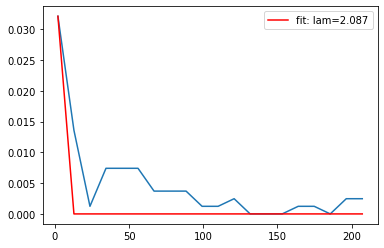

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def exp_pdf(x, lam):
    return lam * np.exp(-lam * x)

hist, bin_edges = np.histogram(inter_event_time, bins = 20, density=True)
popt, pcov = curve_fit(exp_pdf, bin_edges[:-1], hist)
plt.plot(bin_edges[:-1], hist)
plt.plot(bin_edges[:-1], exp_pdf(bin_edges[:-1], *popt), 'r-', label='fit: lam=%5.3f' % tuple(popt))
plt.legend()
plt.show()

### Side by side plot

In [20]:
all_inter_event_dist_time['greater_distance'] = all_inter_event_dist_time['inter_event_col_dist'] > 100

C:\Users\USER\Anaconda3\lib\site-packages\seaborn\axisgrid.py:311: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



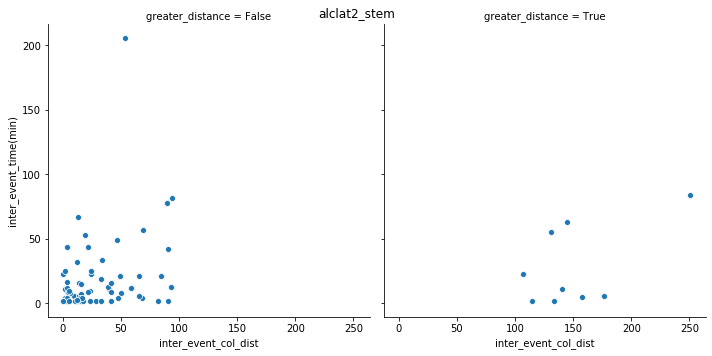

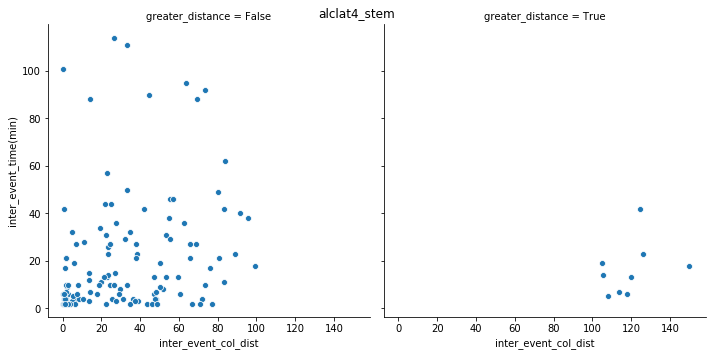

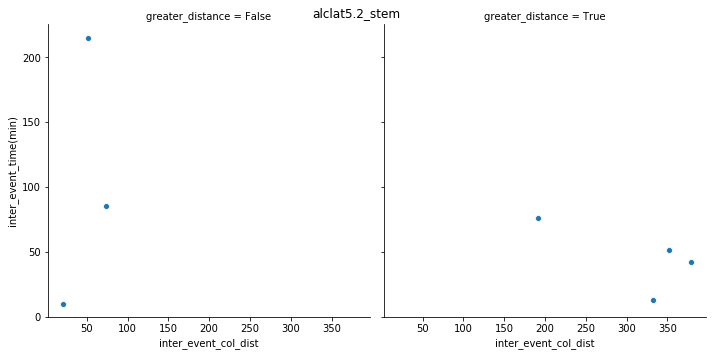

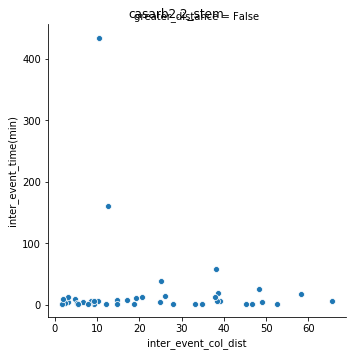

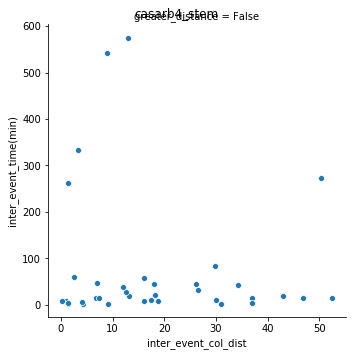

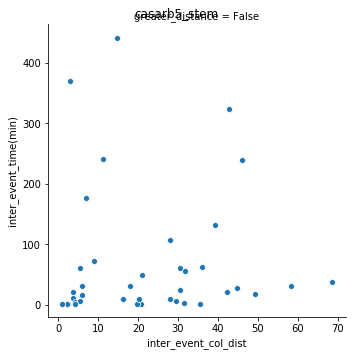

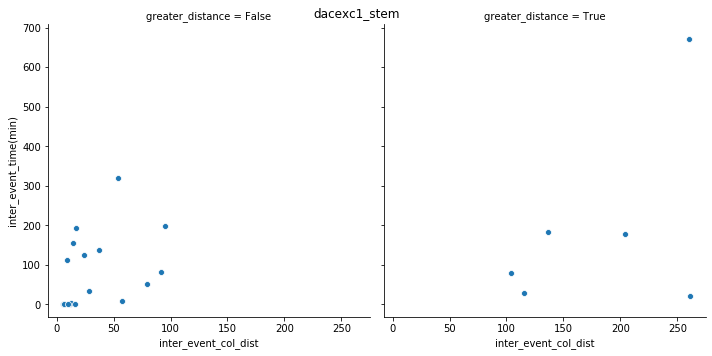

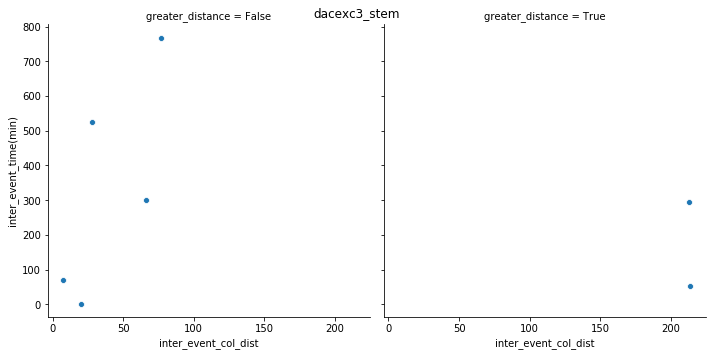

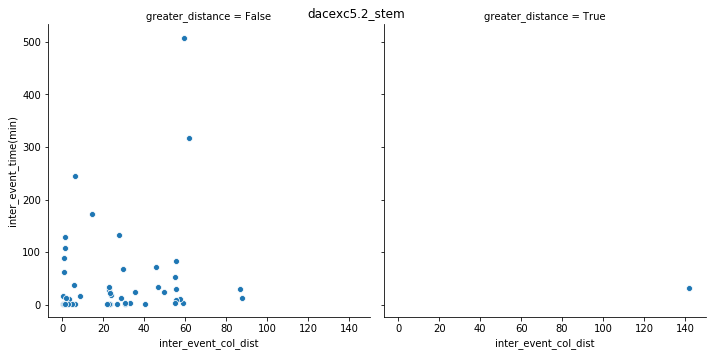

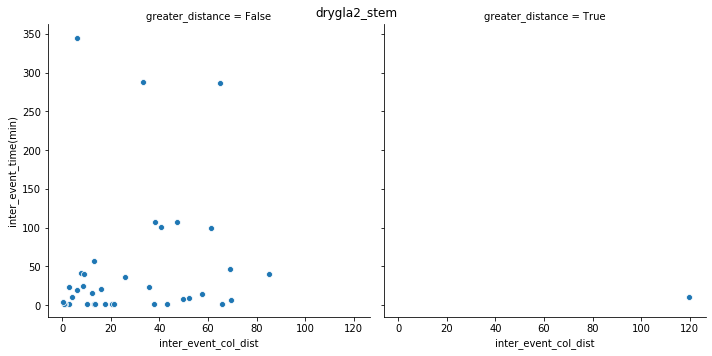

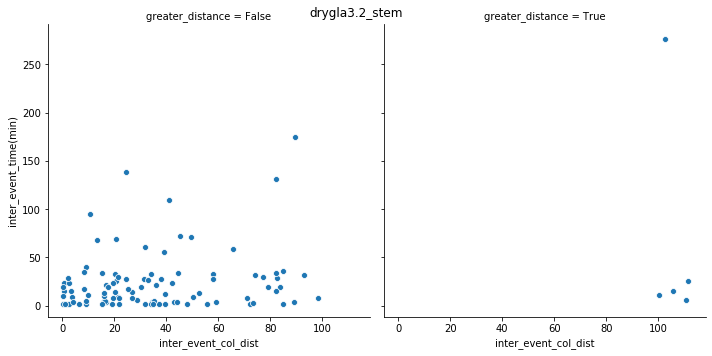

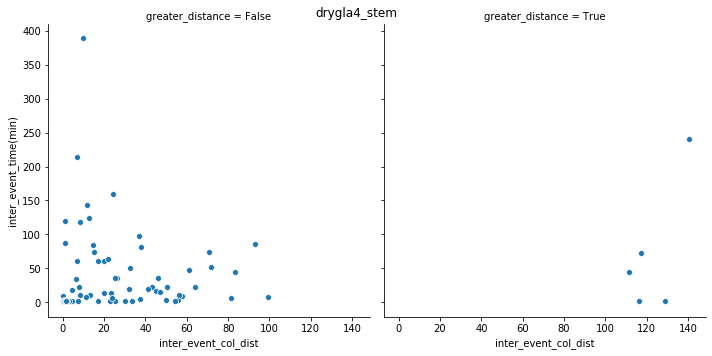

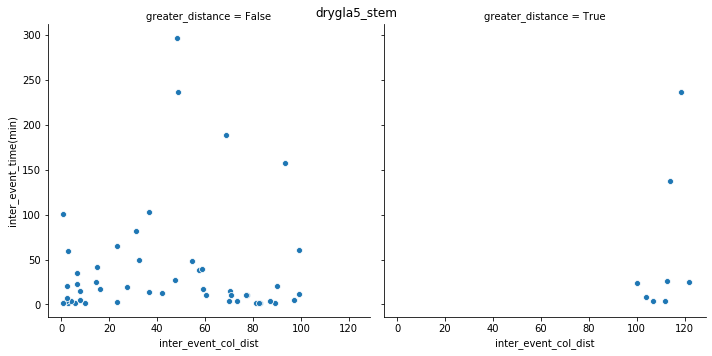

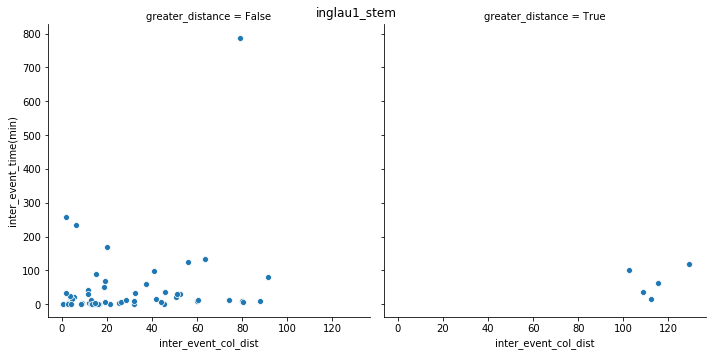

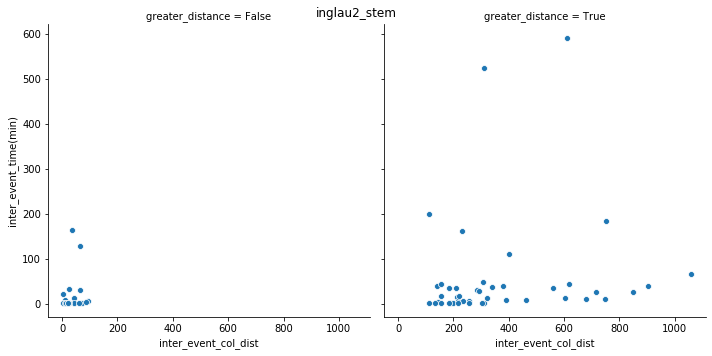

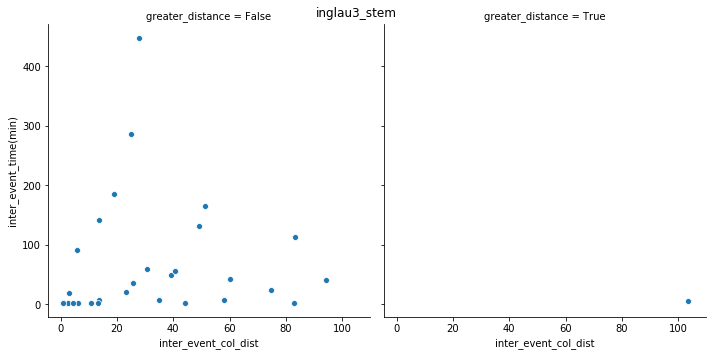

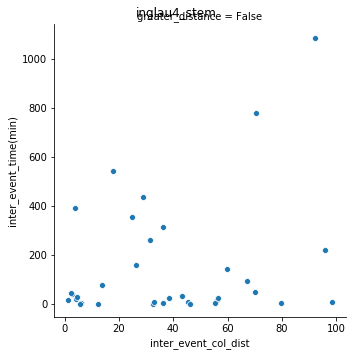

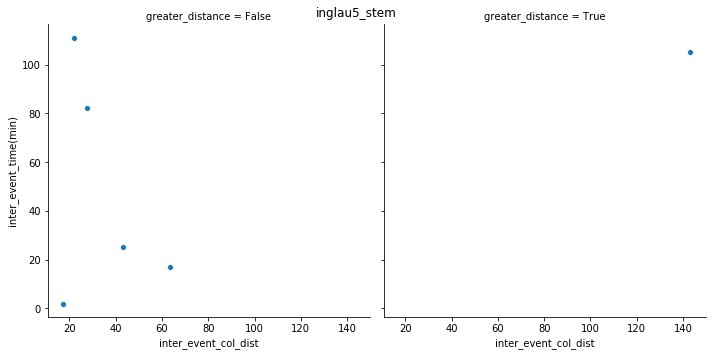

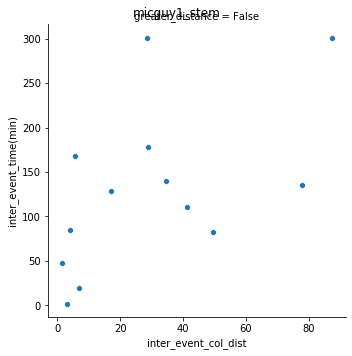

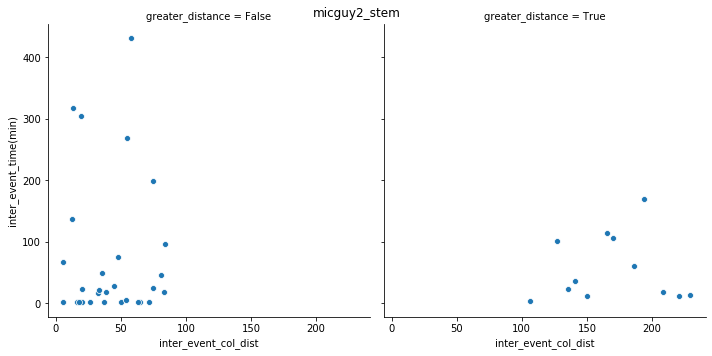

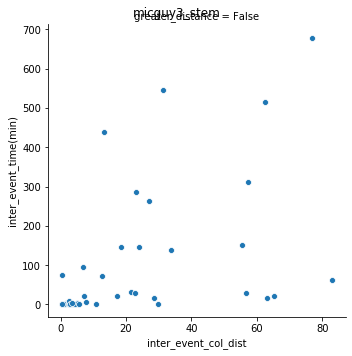

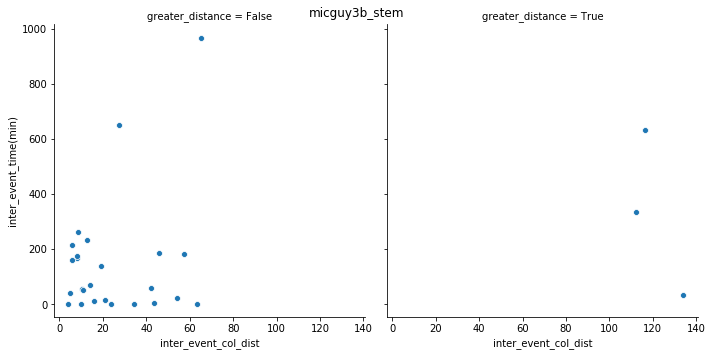

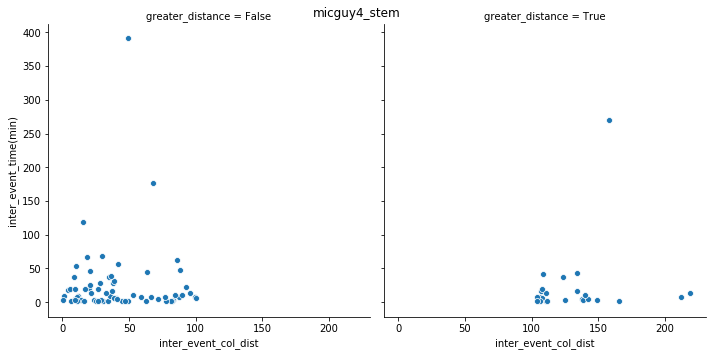

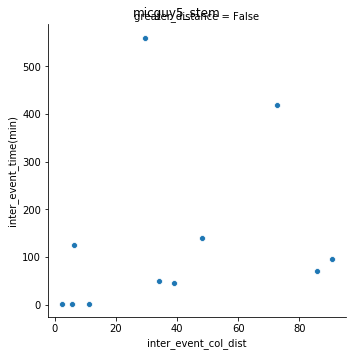

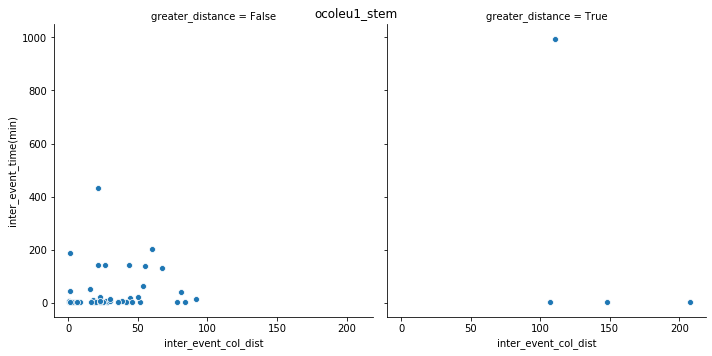

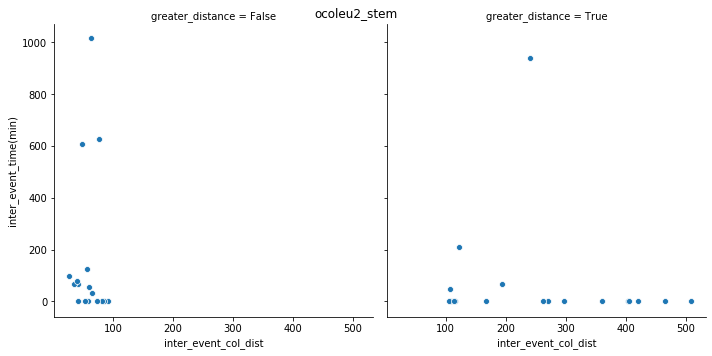

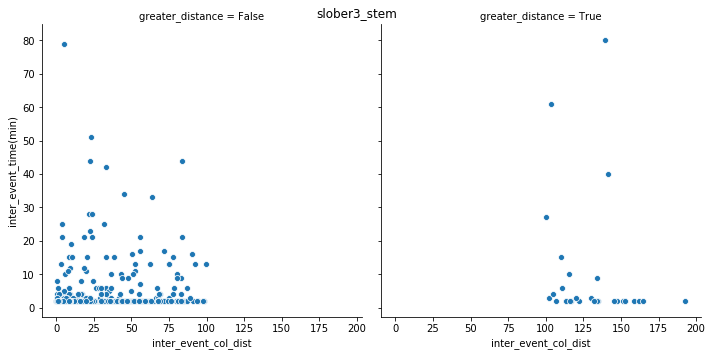

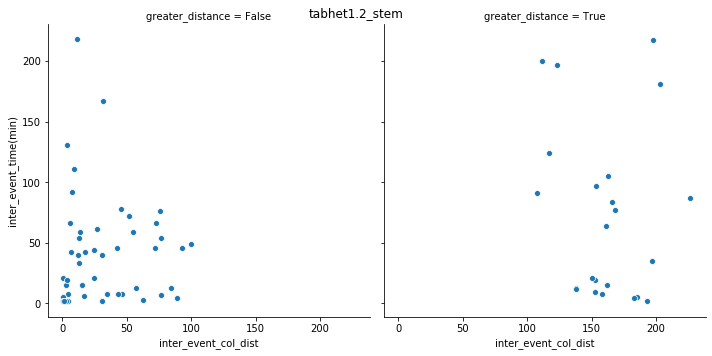

In [21]:
for name in all_inter_event_dist_time.folder_name.unique():
    sns.relplot(data = all_inter_event_dist_time[all_inter_event_dist_time.folder_name == name],x = 'inter_event_col_dist', 
                y = 'inter_event_time(min)',col = 'greater_distance')
    plt.suptitle(name)

In [22]:
all_inter_event_dist_time[all_inter_event_dist_time.folder_name == 'alclat2_stem']

inter_event_col_dist  inter_event_time(min)   folder_name species  \
1               3.410698                    2.0  alclat2_stem  alclat   
2              13.406470                   67.0  alclat2_stem  alclat   
3              46.535420                   49.0  alclat2_stem  alclat   
4              14.353293                   16.0  alclat2_stem  alclat   
5             145.050647                   63.0  alclat2_stem  alclat   
..                   ...                    ...           ...     ...   
75              2.308286                   25.0  alclat2_stem  alclat   
76             41.458482                    9.0  alclat2_stem  alclat   
77             69.074131                   57.0  alclat2_stem  alclat   
78              0.496889                    2.0  alclat2_stem  alclat   
79             53.230480                  206.0  alclat2_stem  alclat   

    rel_exp_idx  greater_distance  
1             1             False  
2             1             False  
3             1             False  
4             1             False  
5             1              True  
..          ...               ...  
75            1             False  
76            1             False  
77            1             False  
78            1             False  
79            1             False  

[79 rows x 6 columns]

# Save into csv files

In [23]:
all_inter_event_dist_time.to_csv(os.path.join(input_dir,'all_inter_event_dist_time.csv'),index=True)

In [24]:
total_summary_stats.to_csv(os.path.join(input_dir,'total_summary_stats.csv'),index=True)

## Note
Haven't include these folders where the total number of images with embolism event > 750): 
OCOLEO5_Stem.DONEGOOD.HANNAH.12.17
SLOBER2_Stem.DONEGOOD.HANNAH.12.23